In [1]:
import numpy as np
from scipy.stats import gennorm, norm
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.stats import binned_statistic

In [2]:
def bin_data(data, 
             min_ct=10, 
             num_bins=10, 
             ascending=False, 
             noise=1E-6, 
             max_iterations=100, 
             verbose=False):
    """
    Bin data for use in NA regression
    
    parameters
    ----------
    
    data: (array-like)
        Data to bin. Must be castable as a one-dimensional numpy array or floats.
        
    min_ct: (int > 0 and <= len(data)/2)
        Minimum number of data points to include in each bin.
        
    num_bins: (int >= 2)
        Number of bins in which to bin data.
        
    ascending: (bool)
        Specifies direction in which bins are computed. 
    
    noise: (float >= 0 or None)
        Noise to add to data to avoid ties, in units of the data's standard deviation.
        
    verbose: (bool)
        Whether to provide printed feedback. Only needed for debugging purposes. 
        
    returns
    -------
    
    data_bins: (np.ndarray)
        Array listing the bins that each data point is assigned to.
        
    bin_df: (pd.DataFrame)
        Dataframe listing bin boundaries, counts, and lengths.
    
    """   

    # Cast data as np.array
    data = np.array(data)

    # Get number of data points
    N = len(data)
    
    # Add purturbation to data to avoid ties
    noise *= np.std(data)
    data = np.array(data) + noise*np.random.randn()
    
    # Cast min_ct as int
    min_ct = int(min_ct)
    
    # If min_ct is <= 0, raise error
    assert min_ct > 0, f'Invalid value min_ct={min_ct}.'
    
    # Make sure min_ct isn't too big
    assert min_ct <= N/2, f'min_ct={min_ct} is too large; must be <= N/2={N/2}'
    
    # Make sure num_bins is valid
    assert num_bins >= 2, f'Invalid value for num_bins={num_bins}'
 
    # Simplified function to compute binning using upper bound length
    def f(l, return_results=False):
        data_bins, bin_df = _bin_data_usin_min_length(data, 
                                                      min_ct=min_ct, 
                                                      min_length=l, 
                                                      ascending=ascending)
        n = len(bin_df)
        if verbose:
            print(f'n:{n}, l:{l:.4f}')
        return n, data_bins, bin_df
            

    # Start with what should be an upper bound on min_length l
    span_ub = max(data)-min(data)
    l = span_ub/num_bins
    
    # Compute n given l
    n, data_bins, bin_df = f(l)
    
    # If n is correct, return results
    if n == num_bins:
        return data_bins, bin_df
    
    # Otherwise, make sure n < num_bins and upper bound on l
    assert n < num_bins, f'Error: n={n} > num_bins={num_bins}'
    l_ub = l
    if verbose:
        print(f'n:{n} -> l_ub:{l_ub}')
    
    # Reduce l until a lower bound is found, or max iterations are exceeded
    for k in range(1,max_iterations+1):
        
        # Reduce the value of l
        l = l_ub/(2**k)
        
        # Compute n given l
        n, data_bins, bin_df = f(l)
    
        # If n is too big, set l as lower bound and break out of for loop
        if n > num_bins:
            l_lb = l
            if verbose:
                print(f'n:{n} -> l_lb:{l_lb}')
            break;
    
        # If n is too small, check to make sure continuing with the calculation is worth it
        elif n < num_bins:
            
            # If shrinking bins any more won't help, return results
            if sum(bin_df['count'] > min_ct) <= 1:
                print(f'Cant get more than n={n} bins with min_ct={min_ct}. Using {n} bins.' )
                return data_bins, bin_df
    
        # Otherwise, n is correct. Return results.
        else:
            assert n == num_bins
            return data_bins, bin_df
    
    # Perform binary search until correct n is found, or max iterations are exceeded
    if verbose:
        print('(stage 3)')
    for k in range(1,max_iterations+1):
        
        # Set new min_lenfth
        l = (l_lb + l_ub)/2
        
        # Compute n given l
        n, data_bins, bin_df = f(l)
        if verbose:
            print(f'l:{l}, l_ub:{l_ub}, l_lb:{l_lb}')
            
        # If n is correct, return results
        if n == num_bins:
            return data_bins, bin_df
        
        # If n is too large, adjust lower bound  upward
        if n > num_bins:
            l_lb = l
            
        # If n is too small, adjust upper bound downward
        elif n < num_bins:
            l_ub = l
            
        # Otherwise, n is correct. Return results.
        else:
            assert n == num_bins
            return data_bins, bin_df
        
    print('Failed to converge. Returning last results. ')
    return data_bins, bin_df    


def _bin_data_usin_min_length(data, min_ct, min_length, ascending):
    """
    Utility function used in bin_data(). 
    
    parameters
    ----------
    
    data: (array-like)
        Data to bin. Must be castable as a one-dimensional numpy array or floats.
        
    min_ct: (int > 0 and <= len(data)/2)
        Minimum number of data points to include in each bin.
        
    min_length: (float > 0)
        Minimum length of a bin. If set, overrides max_bins.
        
    ascending: (bool)
        Specifies direction in which bins are computed. 
        
    returns
    -------
    
    data_bins: (np.ndarray)
        Array listing the bins that each data point is assigned to.
        
    bin_df: (pd.DataFrame)
        Dataframe listing bin boundaries, counts, and lengths.
    
    """
        
    # Cast data as np.array
    data = np.array(data)
    
    # Make sure min_ct is an int
    min_ct = int(min_ct)
    
    # Get number of data points
    N = len(data)
    
    # Sort data
    sorted_data = np.sort(data)
    if not ascending:
        sorted_data = -sorted_data[::-1]
    
    # Compute edges
    edge_min = sorted_data[0]
    edge_max = sorted_data[-1]

    # Initialize n, edges, and cts
    n = -1
    edge = edge_min
    edges = np.array([edge])
    ns = np.array([n])
    while (n < N-min_ct-1) and (edge < edge_max-min_length):

        n_new_a = n + min_ct
        edge_new_a = .5*(sorted_data[n_new_a]+sorted_data[n_new_a+1])

        edge_new_b = edge + min_length
        n_new_b = np.searchsorted(sorted_data, edge_new_b)

        n = max(n_new_a, n_new_b)
        edge = max(edge_new_a, edge_new_b)

        # Record edge and n
        edges = np.append(edges,edge)
        ns = np.append(ns,n)

    # Add upper bound to edges if needed
    if (n < N) and (edge < edge_max):
        edges = np.append(edges, edge_max)
        ns = np.append(ns, N)

    # Remove second-to-last edge if cts in last bin is too small
    cts = np.diff(ns)
    if cts[-1] < min_ct:
        edges = np.delete(edges,-2)

    # If descending, reverse edges. Note that this might mess up cts a bit.
    if not ascending:
        edges = -edges[::-1]
        
    # Make sure that cts agrees with histogram
    cts, _ = np.histogram(data, edges)

    # Create a dataframe to hold results
    bin_df = pd.DataFrame()
    bin_df['count'] = cts
    bin_df['left_in'] = edges[:-1]
    bin_df['right_ex'] = edges[1:]
    bin_df['length'] = bin_df['right_ex'] - bin_df['left_in'] 
    
    # Compute bin index for each data point
    _, _, data_bins = binned_statistic(data, data, statistic='mean', bins=edges, range=None)
    
    # Return dataframe
    return data_bins-1, bin_df

In [3]:
### Simulate data

# Generate signal data
N_signal = int(1E4)
signal_data = 10*(1+gennorm(beta=8).rvs(N_signal))

# Generate background data
N_background = int(1E5)
background_data = 2*norm().rvs(N_background)

# Gather into all N and shuffle
data = np.concatenate([signal_data, background_data])
np.random.shuffle(data)

In [4]:
### Bin data
min_ct = 2000
num_bins = 20
data_bins, bin_df = bin_data(data, 
                             min_ct = min_ct,
                             num_bins = num_bins,
                             ascending=False,
                             verbose=False)

bin_df

,count,left_in,right_ex,length
0,2817,-8.528455,-3.821509,4.706947
1,2416,-3.821509,-3.252643,0.568865
2,3795,-3.252643,-2.683778,0.568865
3,5487,-2.683778,-2.114912,0.568865
4,7560,-2.114912,-1.546047,0.568865
5,9185,-1.546047,-0.977182,0.568865
6,10805,-0.977182,-0.408316,0.568865
7,11397,-0.408316,0.160549,0.568865
8,11141,0.160549,0.729415,0.568865
9,10138,0.729415,1.298280,0.568865


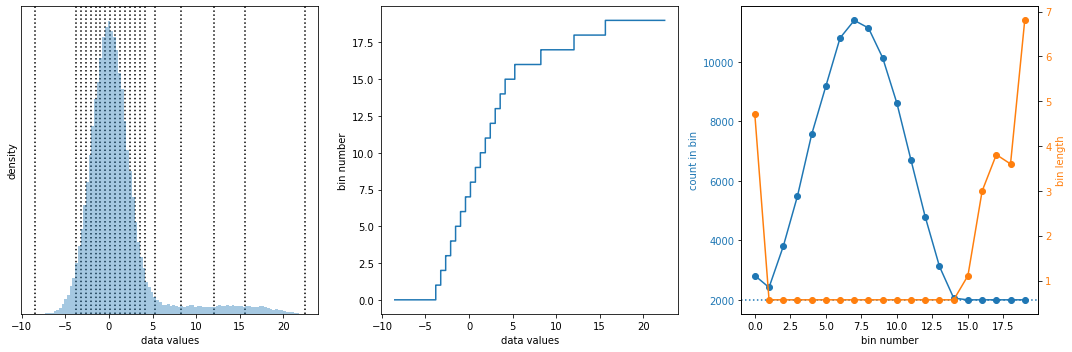

In [5]:
### Plot results

# Create figure and axes
fig, axs = plt.subplots(1,3, figsize=[15,5])
axs = axs.ravel()

# Plot data histogram and edge locations
ax = axs[0]
sns.distplot(data, bins=100, ax=ax, kde=False)
edges = bin_df['left_in'].values
edges = np.append(edges,bin_df['right_ex'].values[-1])
for edge in edges:
    ax.axvline(edge, linestyle=':', color='k', zorder=-100)
ax.set_yticks([])
ax.set_xlabel('data values')
ax.set_ylabel('density')
    
# Plot bin nubmers against data values
ax = axs[1]
ix = np.argsort(data)
ax.step(data[ix],data_bins[ix])
ax.set_ylabel('bin number')
ax.set_xlabel('data values')
    
# Plot counts per bin for each bin
ax1 = axs[2]
color = 'C0'
x = bin_df.index
y1 = bin_df['count']
y2 = bin_df['length']
ax1.plot(x,y1,'-o', color=color)
ax1.axhline(min_ct, color=color, linestyle=':')
ax1.set_ylabel('count in bin', color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xlabel('bin number')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'C1'
ax2.set_ylabel('bin length', color=color)  # we already handled the x-label with ax1
ax2.plot(x, y2, '-o', color=color)
ax2.tick_params(axis='y', labelcolor=color)

# Save figure
fig.tight_layout()
fig.savefig('adaptive_binning.pdf')